## 1. 初始準備

In [1]:
%env KERAS_BACKEND = tensorflow

env: KERAS_BACKEND=tensorflow


In [59]:
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Dense, Input, Activation
from keras.layers import Lambda, concatenate
from keras.optimizers import Nadam

from keras.utils import np_utils
from keras import backend as K

from keras.datasets import mnist

讀取 mnist 手寫資料

In [8]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [12]:
x_train = x_train.reshape(60000,28*28)
x_test = x_test.reshape(10000, 28*28)

將pixel-value值範圍變為0~1之間

In [13]:
x_train = x_train/255
x_test = x_test/255

## 2. Autoencoder

autoencoder，又稱為自編碼器，是一個將資料壓縮再還原的模型，是由一編碼器與解碼器所結合而成的函數。

In [14]:
enc_1 = Dense(100, activation='sigmoid')
enc_2 = Dense(2, activation='sigmoid')

dec_2 = Dense(100, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

In [17]:
x = Input(shape=(784,))

In [18]:
enc_x = enc_1(x)
h = enc_2(enc_x)
dec_x = dec_2(h)
x_reconstructed = dec_1(dec_x)

Instructions for updating:
Colocations handled automatically by placer.


In [19]:
autoencoder = Model(x, x_reconstructed)
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
_________________________________________________________________
dense_3 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_4 (Dense)              (None, 784)               79184     
Total params: 158,186
Trainable params: 158,186
Non-trainable params: 0
_________________________________________________________________


In [22]:
autoencoder.compile(loss='kullback_leibler_divergence',optimizer='Nadam')

In [23]:
autoencoder.fit(x_train, x_train, batch_size=32, epochs=100)

Epoch 1/100
60000/60000 [==============================] - 6s 101us/step - loss: -22.0501
Epoch 2/100
16740/60000 [=======>......................] - ETA: 4s - loss: -22.0288

KeyboardInterrupt: 

In [27]:
autoencoder.load_weights('autoencoder_handwriting_model_weights.h5')

## 3. 視覺化 - 子模型的取出

In [28]:
Encoder = Model(x, h)
Encoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


In [30]:
h_input = Input(shape=(2,))

Decoder = Model(h_input, dec_1(dec_2(h_input)))
Decoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_4 (Dense)              (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


### 2.1 視覺化 - Encoder

In [57]:
index = np.random.randint(x_train.shape[0])
print('第 %d 圖的 latent 表示為 %s' %(index, 
                                Encoder.predict(x_train[index:index+1])))

print(Encoder.predict(x_train[index:index+1])[0][1])

第 27605 圖的 latent 表示為 [[0.20361201 0.6795541 ]]
0.6795541


In [55]:
idices = np.random.randint(x_test.shape[0], size=1000)

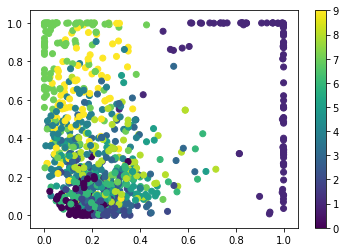

In [60]:
latents = Encoder.predict(x_test[idices])
plt.scatter(latents[:,0],latents[:,1],c=y_test[idices])
plt.colorbar()
plt.show()

### 2.1 視覺化 - Decoder

In [97]:
n = 15
digit_size = 28
figure = np.zeros((digit_size*n, digit_size*n))

grid_x = np.linspace(0.05,0.95,n)
grid_y = np.linspace(0.05,0.95,n)

In [98]:
for i, xi in enumerate(grid_x):
    for j, yi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = Decoder.predict(z_sample)

        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[(n-i-1)*digit_size:(n-i)*digit_size, j*digit_size:(j+1)*digit_size]=digit

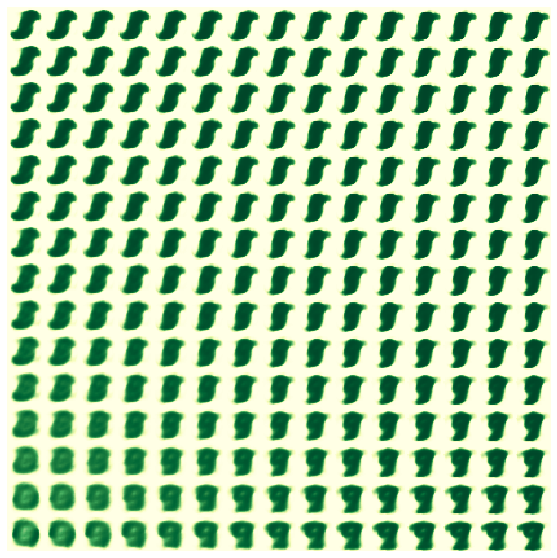

In [99]:
plt.figure(figsize=(10,10))
plt.imshow(figure, cmap='YlGn')
plt.axis('off')
plt.show()